In [1]:
from SAC.Normal_Policy import Normal_Policy
from SAC.Value_function import Value_function
from SAC.SoftActorCritc import SoftActorCritic, plot

import time
import gym
import numpy as np

import sys
sys.path.insert(0, './laser-hockey-env')
import laser_hockey_env as lh
from importlib import reload


In [2]:
env = lh.LaserHockeyEnv(mode=lh.LaserHockeyEnv.TRAIN_SHOOTING)

In [3]:
ac_space = env.action_space
o_space = env.observation_space
print(ac_space.low)
print(o_space)

[-1. -1. -1. -1. -1. -1.]
Box(16,)


In [4]:
q_fct_config = {"hidden_layers": [300, 300]}
v_fct_config = {"hidden_layers": [300, 400]}
pi_fct_config = {"hidden_layers": [200, 200], "dim":3}

SAC_agent = SoftActorCritic(o_space=o_space, 
                            a_space=ac_space, 
                            value_fct=Value_function, 
                            policy_fct=Normal_Policy, 
                            env= env,
                            discount=  0.99, 
                            tau = 0.01, 
                            batch_size=256, 
                            alpha = 0.4,
                            lambda_V = 1e-3, 
                            lambda_Pi = 1e-3, 
                            lambda_Q = 1e-3,
                            dim = 3,
                            q_fct_config=q_fct_config,
                            v_fct_config=v_fct_config,
                            pi_fct_config=pi_fct_config  ) 

In [ ]:
import progressbar

def train(iter_fit=1000, max_steps= 500, env_steps = 1, grad_steps = 1, burn_in =1000):
        bar = progressbar.ProgressBar(max_value=iter_fit)
        # Initilalize target V network
        SAC_agent._sess.run(SAC_agent._update_target_V_ops_hard)
        # Init Statistics      
        total_rewards_per_episode = [] 
        total_loss_V = []
        total_loss_Q1 = []
        total_loss_Q2 = []
        total_loss_PI = []
        
        
        j = 0
        for i in range(iter_fit):
            
            ob = env.reset() 
            total_reward = 0
            for _ in range(max_steps):
                for e_i in range(env_steps):#
                    #env.render()
                    if j < burn_in:
                        a = env.action_space.sample()
                        a = a[:3]
                        #a = self.reverse_action(a)    
                                        
                    else:
                        a = SAC_agent.action(np.asarray(ob).reshape(1, SAC_agent._o_space.shape[0]))
                        a = a[0]
                    a2 = [0,0.,0]  
                    comb_a = np.hstack([a,a2])
                    (ob_new, reward, done, _info) = env.step(comb_a)
                    reward += _info['winner']*1+  + _info['reward_closeness_to_puck']*1.  + _info['reward_touch_puck']*1  + _info['reward_puck_direction']*1
                    total_reward += reward
                    SAC_agent.store_transition(ob, a, reward, ob_new, done)
                    ob=ob_new
  
                if j  >= SAC_agent._config["batch_size"]:
                    for g_i in range(grad_steps):
                        update_value_target = False
                        if i % SAC_agent._config["target_update"] == 0:
                            update_value_target = True
                        loss_V_fct, loss_Q1_fct,loss_Q2_fct,loss_PI_fct= SAC_agent._train(update_value_target)
                        total_loss_V.append(loss_V_fct)
                        total_loss_Q1.append(loss_Q1_fct)
                        total_loss_Q2.append(loss_Q2_fct)
                        total_loss_PI.append(loss_PI_fct)        
                j += 1
                if done:
                    break   
            total_rewards_per_episode.append(total_reward)
            if i % 1 == 0:
                plot(total_rewards_per_episode,total_loss_V,total_loss_Q1, total_loss_Q2, total_loss_PI) 
            bar.update(i)   
        return total_rewards_per_episode

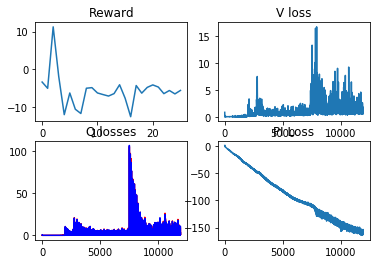

  2% (25 of 1000) |                      | Elapsed Time: 0:04:44 ETA:   3:30:24

In [ ]:
train()

In [ ]:
env.close()

In [ ]:
ob = env.reset()
env.render()

In [ ]:
for _ in range(1000):
    env.render()
    a = SAC_agent.act_greedy(np.asarray(ob).reshape(1, SAC_agent._o_space.shape[0]))
    a1 = a[0]
    a2 = [0,0,0] 
    obs, r, d, info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    if d: break
env.close()